In [2]:
# imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import re
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases, TfidfModel, CoherenceModel
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaMallet
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy
import en_core_web_sm
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
#nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nltk.download('wordnet')
stop_words = stopwords.words('english')

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


# Functions

## Data Loading

In [3]:
def load_data(folder_path):
    data = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.xml'):
            file_path = folder_path + '/' + filename
            
            with open(file_path, 'r') as f:
                text = f.read()
            f.closed
            
            text = text.strip().replace('\n', '')
            sentences = re.findall(r'<sentence .*?>(.*?)</sentence>+', text)
            name = re.findall(r'<name>(.*?)</name>+', text)[0]

            # ako bude trebao name vrati ovo
            # U TOM SLUCAJU procitaj komentar ispod
            # documents je lista dokumenata, gde je svaki dokument lista od dva elementa: prvi je naslov, a drugi lista recenica!
            #data.append([name, sentences])
            
            data.append(sentences)
            
    return data

In [4]:
# pretvara listu recenica svakog od dokumenata u plaintext
def create_plaintext_from_sentences(documents):
    data = []
    
    for document in documents:
        data.append(' '.join(document))
        
    return data

## Preprocessing

In [5]:
# tokenization and stopwords removing 
def preprocess(text):
    result = []
    #stemmer = PorterStemmer()
    #lemmatizer = WordNetLemmatizer()
    
    for token in simple_preprocess(text):                       # deacc=True za uklanjanje znakova interpunkcije
        if token not in stop_words and len(token) > 3:
            result.append(token)
            
    return result

In [6]:
# lemmatization with pos tagging (work with nouns, adjectives, verbs and adverbs)
def lemmatization(documents, allowed_pos_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    documents_out = []
    
    for document in documents:
        if(len(document) > 100000 or len(document) < 10):   # da ne obradjuje prevelike dokumente, ima problema sa memorijom, a i svakako mi ne trebaju
            print(len(document))
        else:
            doc = nlp(' '.join(document))
            documents_out.append([token.lemma_ for token in doc if token.pos_ in allowed_pos_tags])
        
    return documents_out

## Phrase modeling using ngrams

In [7]:
def create_ngram_models(documents):
    bigram = Phrases(documents, min_count=5, threshold=100)
    trigram = Phrases(bigram[documents], threshold=100)
    
    bigram_model = Phraser(bigram)
    trigram_model = Phraser(trigram)
    
    return bigram_model, trigram_model

In [8]:
def make_bigrams(documents, bigram_model):
    return [bigram_model[document] for document in documents]

def make_trigrams(documents, trigram_model):
    return [trigram_model[document] for document in documents]

## Dictionary and corpus for LDA

In [9]:
def create_dictionary(documents):
    return Dictionary(documents)

def create_corpus(documents, dictionary):
    return [dictionary.doc2bow(document) for document in documents]

## Build LDA topic model

In [10]:
def build_lda_model(dictionary, corpus, lda_params, use_mallet=True):
    num_topics, alpha, beta = lda_params
    
    if(use_mallet):
        mallet_path = 'C:/mallet/mallet-2.0.8/bin/mallet.bat'
        lda_model = LdaMallet(mallet_path,
                              corpus=corpus,
                              id2word=dictionary,
                              num_topics=num_topics,
                              alpha=alpha)
    else:
        lda_model = LdaModel(corpus=corpus,
                             id2word=dictionary,
                             num_topics=num_topics,
                             random_state=33,
                             update_every=1,
                             chunksize=100,
                             passes=10,
                             alpha=alpha,
                             eta=beta,
                             per_word_topics=True)
    
    return lda_model

## Evaluation using coherence score

In [11]:
# Coherence
def get_coherence_score_lda(lda_model, dictionary, texts):
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

## Find optimal number of topics for LDA

In [12]:
def find_best_number_of_topics(dictionary, corpus, texts, limit, start=2, step=3):    
    coherence_values = []
    model_list = []
    i = 0
    
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=33,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         eta=0.001,
                         per_word_topics=True)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        i += 1
        print('Done ' + str(i))
        
    return model_list, coherence_values

def plot_coherence_scores(coherence_values, limit, start=2, step=3):
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')

## Topics - keywords visualization

In [13]:
def topics_visualization(lda_model, corpus, dictionary):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
    return vis

## Create feature vector of topics distribution for every document

In [14]:
def create_topics_feature_vector(lda_model, dictionary, corpus, num_topics):
    feature_vectors = []
    
    for document in corpus:
        top_topics = lda_model.get_document_topics(document, minimum_probability=0.0)
        topics_vector = [top_topics[i][1] for i in range(num_topics)]
        feature_vectors.append(topics_vector)
        
    return feature_vectors

## Create dataframe of feature vectors and export it to pickle file

In [15]:
def create_feature_dataframe(feature_vectors):
    num_topics = len(feature_vectors[0])
    columns = ['topic_{}'.format(i) for i in range(num_topics)]
    df = pd.DataFrame(data=feature_vectors, columns=columns)
    return df

In [16]:
def export_dataframe(dataframe, file_name='documents_topics.pkl'):
    dataframe.to_pickle(file_name)

## Save/Load model

In [17]:
def save_model(lda_model, path='lda.model'):
    lda_model.save(path)

In [18]:
def load_model(path='lda.model'):
    return LdaModel.load(path)

## Find dominant topic in each document

In [68]:
def get_dominant_topic(lda_model, corpus, texts):
    doc_topics_df = pd.DataFrame()

    for doc in corpus:
        topics = lda_model.get_document_topics(doc, minimum_probability=0.0)
        dominant_topic = max(topics, key=lambda x: x[1])   # tuple: topic number, topic weight

        topic = lda_model.show_topic(dominant_topic[0])
        keywords = ', '.join([word for word, weight in topic])

        doc_topics_df = doc_topics_df.append(pd.Series([int(dominant_topic[0]), round(dominant_topic[1], 4), keywords]), ignore_index=True)

    doc_topics_df.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords']        
    
    temp = []
    for text in texts:
        temp.append(' '.join(text))
        
    doc_topics_df['text'] = temp
    return doc_topics_df

## Find most representative document for each topic

In [73]:
# grupisanje po temi i uzimanje dokumenta sa max tezinom u okviru svake grupe
# TODO: dodaj 
def get_representative_documents(doc_topics_df):
    df = doc_topics_df.groupby('dominant_topic').max(key='perc_contribution').reset_index()
    df.columns = ['topic', 'perc_contribution', 'topic_keywords', 'text']
    return df

## Export dataframe to cvs or pickle format

In [83]:
def export_dataframe(dataframe, path, file_format='csv'):
    if file_format == 'csv':
        dataframe.to_csv(path, index=False)
    elif file_format == 'pkl':
        dataframe.to_pickle(path, index=False)

# Apply functions on Legal Case Reports Dataset

### Data loading

In [19]:
documents = load_data('corpus/fulltext')
print('\n'.join(documents[0])) 

 Background to the current application  1 The applicants Sharman Networks Ltd ('Sharman Networks'), Sharman License Holdings Ltd ('Sharman License') and Ms Nicola Anne Hemming ('Ms Hemming') are each the subject of asset preservation orders made by Wilcox J on 22 March 2005 ('the Mareva orders').
When referring to the applicants generally, I will do so as 'the Sharman applicants'.
Each of the Sharman applicants was one of ten respondents to infringement of copyright proceedings brought by the present respondents ('the Music companies') in respect of the operation of what was described by the parties as the 'Kazaa system' ('the primary proceedings').
Wilcox J made orders ancillary to the Mareva orders on 22 March 2005 requiring each of the Sharman applicants to disclose on affidavit the description and value of all of their assets, wherever situated, and to specify whether those assets were held by each applicant either beneficially or in trust for any other person or entity.
2 Wilcox J

Associate:Dated: 5 January 2006 Counsel for the First, Second and Third Applicants: J M Ireland QC   Solicitor for the First, Second and Third Applicants: Clayton Utz   Counsel for the First to Thirtieth Respondents: R Cobden SC and J M Hennessy   Solicitor for the First to Thirtieth Respondents: Gilbert + Tobin   Date of Hearing: 30 November and 1 December 2005   Date of Judgment: 5 January 2006    AustLII: Copyright Policy | Disclaimers | Privacy Policy | Feedback  URL: http://www.austlii.edu.au/au/cases/cth/FCA/2006/1.html   


In [20]:
# transform lists of sentences into plaintext
documents = create_plaintext_from_sentences(documents)
print(documents[0])

 Background to the current application  1 The applicants Sharman Networks Ltd ('Sharman Networks'), Sharman License Holdings Ltd ('Sharman License') and Ms Nicola Anne Hemming ('Ms Hemming') are each the subject of asset preservation orders made by Wilcox J on 22 March 2005 ('the Mareva orders'). When referring to the applicants generally, I will do so as 'the Sharman applicants'. Each of the Sharman applicants was one of ten respondents to infringement of copyright proceedings brought by the present respondents ('the Music companies') in respect of the operation of what was described by the parties as the 'Kazaa system' ('the primary proceedings'). Wilcox J made orders ancillary to the Mareva orders on 22 March 2005 requiring each of the Sharman applicants to disclose on affidavit the description and value of all of their assets, wherever situated, and to specify whether those assets were held by each applicant either beneficially or in trust for any other person or entity. 2 Wilcox J

### Preprocessing

In [21]:
# it might take a while
preprocessed_docs = []
for document in documents:
    preprocessed_docs.append(preprocess(document))

In [23]:
print(' '.join(preprocessed_docs[0]))

background current application applicants sharman networks sharman networks sharman license holdings sharman license nicola anne hemming hemming subject asset preservation orders made wilcox march mareva orders referring applicants generally sharman applicants sharman applicants respondents infringement copyright proceedings brought present respondents music companies respect operation described parties kazaa system primary proceedings wilcox made orders ancillary mareva orders march requiring sharman applicants disclose affidavit description value assets wherever situated specify whether assets held applicant either beneficially trust person entity wilcox delivered judgment complex issues liability arising primary proceedings september universal music australia sharman license holdings meantime hemming filed disclosure affidavits pursuant wilcox orders march whilst sharman license sharman networks unsuccessfully sought several stays various grounds order insofar applied universal musi

### Create bigrams and trigrams

In [24]:
# trigram model isn't used for now
bigram_model, trigram_model = create_ngram_models(preprocessed_docs)
print(trigram_model[bigram_model[preprocessed_docs[0]]])

['background', 'current', 'application', 'applicants', 'sharman_networks', 'sharman_networks', 'sharman_license_holdings', 'sharman_license', 'nicola', 'anne', 'hemming', 'hemming', 'subject', 'asset_preservation_orders', 'made', 'wilcox', 'march', 'mareva', 'orders', 'referring', 'applicants', 'generally', 'sharman', 'applicants', 'sharman', 'applicants', 'respondents', 'infringement_copyright', 'proceedings', 'brought', 'present', 'respondents', 'music_companies', 'respect', 'operation', 'described', 'parties', 'kazaa', 'system', 'primary', 'proceedings', 'wilcox', 'made', 'orders', 'ancillary', 'mareva', 'orders', 'march', 'requiring', 'sharman', 'applicants', 'disclose', 'affidavit', 'description', 'value', 'assets', 'wherever_situated', 'specify', 'whether', 'assets', 'held', 'applicant', 'either', 'beneficially', 'trust', 'person', 'entity', 'wilcox', 'delivered', 'judgment', 'complex', 'issues', 'liability', 'arising', 'primary', 'proceedings', 'september', 'universal_music', 'a

In [26]:
bigrams = make_bigrams(preprocessed_docs, bigram_model)
trigrams = make_trigrams(preprocessed_docs, trigram_model)

### Bigrams lemmatization

In [27]:
# it might take a while
data_lemmatized = lemmatization(bigrams, allowed_pos_tags=['NOUN', 'ADJ', 'VERB', 'ADV'])
texts = data_lemmatized

184190


### Create dictionary and corpus

In [28]:
dictionary = create_dictionary(data_lemmatized)
corpus = create_corpus(data_lemmatized, dictionary)

### Build LDA model

In [29]:
params_lda = (20, 0.1, 0.001)    # num_topics, alpha, eta
lda_model = build_lda_model(dictionary, corpus, params_lda, use_mallet=False)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.045*"court" + 0.041*"order" + 0.026*"proceeding" + 0.024*"cost" + '
  '0.022*"make" + 0.022*"application" + 0.014*"party" + 0.013*"seek" + '
  '0.012*"case" + 0.011*"judgment"'),
 (1,
  '0.055*"document" + 0.031*"information" + 0.015*"make" + 0.013*"letter" + '
  '0.012*"provide" + 0.012*"file" + 0.011*"evidence" + 0.010*"email" + '
  '0.010*"client" + 0.010*"report"'),
 (2,
  '0.030*"work" + 0.027*"employee" + 0.025*"conduct" + 0.019*"site" + '
  '0.017*"contravention" + 0.014*"penalty" + 0.011*"union" + 0.010*"action" + '
  '0.009*"respondent" + 0.009*"make"'),
 (3,
  '0.056*"claim" + 0.048*"patent" + 0.021*"invention" + 0.020*"application" + '
  '0.017*"specification" + 0.012*"say" + 0.010*"product" + 0.010*"would" + '
  '0.009*"gray" + 0.009*"use"'),
 (4,
  '0.042*"claim" + 0.020*"lease" + 0.019*"contract" + 0.015*"property" + '
  '0.015*"offer" + 0.013*"term" + 0.012*"settlement" + 0.012*"rent" + '
  '0.011*"would" + 0.011*"damage"'),
 (5,
  '0.036*"evidence" + 0.029*"sa

### Evaluation

In [30]:
# compute perplexity
# ne radi za LdaMallet
print('\nPerplexity: ', lda_model.log_perplexity(corpus))       # sto nize to bolje

# compute coherence score
coherence_lda = get_coherence_score_lda(lda_model, dictionary, texts)
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -63.27952935821984

Coherence Score:  0.44499965612767955


### Visualization

In [23]:
# this will take a while
vis = topics_visualization(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.052761 -0.073742       1        1  11.759362
0     -0.127768  0.069660       2        1  11.121169
16    -0.064829 -0.027460       3        1   8.407700
9     -0.190776  0.013193       4        1   8.204963
11    -0.153714  0.062469       5        1   5.530326
1     -0.051553  0.008038       6        1   5.047328
14     0.204167  0.090083       7        1   4.829141
18    -0.099752  0.003446       8        1   4.153090
2     -0.009472  0.015987       9        1   4.111607
15    -0.037250 -0.107370      10        1   3.930274
6     -0.139313  0.057744      11        1   3.862557
7      0.125362  0.095362      12        1   3.831675
17     0.076434 -0.116397      13        1   3.716032
12     0.134138 -0.083094      14        1   3.715963
10    -0.023681 -0.038302      15        1   3.630059
19     0.065773  0.180188      16        1   3.448464
4      0.128432  0.099869      17        1   3.412580
13     0.082719  0.122885      18        1   2.973887
8      0.111838 -0.195390      19        1   2.559601
3      0.022007 -0.177167      20        1   1.754222, topic_info=     Category          Freq          Term         Total  loglift  logprob
51    Default  90947.000000     applicant  90947.000000  30.0000  30.0000
776   Default  60743.000000    respondent  60743.000000  29.0000  29.0000
142   Default  67892.000000         claim  67892.000000  28.0000  28.0000
3010  Default  38965.000000      tribunal  38965.000000  27.0000  27.0000
28    Default  32689.000000     agreement  32689.000000  26.0000  26.0000
...       ...           ...           ...           ...      ...      ...
1069  Topic20    737.928589          base  10476.185547   1.3901  -5.2910
1689  Topic20    693.651062  construction   7881.683105   1.6128  -5.3529
736   Topic20    722.175049     reference  12201.993164   1.2161  -5.3126
35    Topic20    769.843323          also  41042.269531   0.0670  -5.2486
751   Topic20    722.553406      relevant  28246.488281   0.3772  -5.3120

[1609 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1430     12  0.988410       abate
3099     15  1.000005  aboriginal
1032      5  1.005693     abridge
5562      2  1.001763     abscond
4633      9  1.000474        accc
...     ...       ...         ...
957      15  0.021143        year
957      17  0.032588        year
957      19  0.001810        year
957      20  0.001616        year
6366     18  1.057671       zohar

[6172 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 17, 10, 12, 2, 15, 19, 3, 16, 7, 8, 18, 13, 11, 20, 5, 14, 9, 4])

### Dominant topic for each document

In [69]:
doc_topics_df = get_dominant_topic(lda_model, corpus, texts)
doc_topics_df.head()

,dominant_topic,perc_contribution,topic_keywords,text
0,0.0,0.4622,"court, order, proceeding, cost, make, applicat...",background current application applicant holdi...
1,0.0,0.3637,"court, order, proceeding, cost, make, applicat...",application order review administrative decisi...
2,1.0,0.3893,"document, information, make, letter, provide, ...",notice motion file bring first second third ap...
3,7.0,0.2371,"agreement, contract, term, party, clause, posi...",introduction brand company know come marketing...
4,16.0,0.2185,"make, section, decision, provision, purpose, n...",context present application appeal application...


In [75]:
representative_docs_df = get_representative_documents(doc_topics_df)
representative_docs_df

,topic,perc_contribution,topic_keywords,text
0,0.0,0.8678,"court, order, proceeding, cost, make, applicat...",yesterday party bring application court adjour...
1,1.0,0.7436,"document, information, make, letter, provide, ...",train series event hope would enable certain a...
2,2.0,0.7537,"work, employee, conduct, site, contravention, ...",young emigrate year year later dead die lapida...
3,3.0,0.6117,"claim, patent, invention, application, specifi...",table content patent construction patent manne...
4,4.0,0.5007,"claim, lease, contract, property, offer, term,...",worldwide stock market collapse couple commonl...
5,5.0,0.5455,"evidence, say, would, give, time, make, could,...",year child proceeding appeal commence responde...
6,6.0,0.7033,"applicant, decision, application, make, review...",tribunal right appeal limited appeal question ...
7,7.0,0.6072,"agreement, contract, term, party, clause, posi...",traxon file application claim damage misleadin...
8,8.0,0.5070,"use, design, register, copyright, licence, mar...",use reference building product consist steel m...
9,9.0,0.9920,"tribunal, appellant, claim, decision, appeal, ...",young postal worker die accident member supera...


### Find optimal number of topics

In [76]:
start = 2
step = 3
limit = 40

In [77]:
model_list, coherence_values = find_best_number_of_topics(dictionary=dictionary, corpus=corpus, texts=texts, limit=limit, start=start, step=step)

Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
Done 12
Done 13


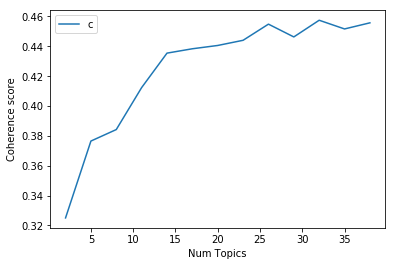

In [78]:
plot_coherence_scores(coherence_values, limit=limit, start=start, step=step)

In [79]:
# print coherence scores
x = range(start, limit, step)
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.325
Num Topics = 5  has Coherence Value of 0.3765
Num Topics = 8  has Coherence Value of 0.3842
Num Topics = 11  has Coherence Value of 0.4124
Num Topics = 14  has Coherence Value of 0.4354
Num Topics = 17  has Coherence Value of 0.4384
Num Topics = 20  has Coherence Value of 0.4406
Num Topics = 23  has Coherence Value of 0.444
Num Topics = 26  has Coherence Value of 0.4549
Num Topics = 29  has Coherence Value of 0.4463
Num Topics = 32  has Coherence Value of 0.4575
Num Topics = 35  has Coherence Value of 0.4516
Num Topics = 38  has Coherence Value of 0.4557


In [80]:
num_topics = x[10]
optimal_model = model_list[10]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(6,
  '0.070*"patent" + 0.068*"claim" + 0.031*"invention" + 0.024*"specification" '
  '+ 0.023*"application" + 0.018*"say" + 0.014*"would" + 0.013*"gray" + '
  '0.010*"method" + 0.010*"refer"'),
 (19,
  '0.078*"notice" + 0.063*"bankruptcy" + 0.043*"debt" + 0.031*"trustee" + '
  '0.026*"judgment" + 0.025*"bankrupt" + 0.022*"debtor" + 0.021*"court" + '
  '0.018*"creditor" + 0.015*"petition"'),
 (16,
  '0.062*"income" + 0.042*"assessment" + 0.035*"commissioner" + '
  '0.031*"taxpayer" + 0.030*"year" + 0.019*"amount" + 0.016*"purpose" + '
  '0.014*"business" + 0.014*"part" + 0.013*"make"'),
 (7,
  '0.096*"scheme" + 0.046*"meeting" + 0.031*"resolution" + 0.027*"member" + '
  '0.025*"vote" + 0.024*"policy" + 0.021*"insurance" + 0.020*"insurer" + '
  '0.019*"propose" + 0.016*"approve"'),
 (12,
  '0.044*"price" + 0.036*"contravention" + 0.031*"market" + 0.030*"conduct" + '
  '0.024*"penalty" + 0.015*"effect" + 0.014*"supply" + 0.014*"make" + '
  '0.012*"impose" + 0.011*"order"'),
 (8,
  '0.17

### Save optimal model

In [91]:
save_model(optimal_model, path='lda.model')

### Test model loading

In [92]:
optimal_model = load_model('lda.model')

### Visualization for optimal model

In [93]:
# this will take a while
vis = topics_visualization(optimal_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18     0.135944  0.032798       1        1  9.398918
31     0.008495  0.050284       2        1  7.509164
20     0.065260  0.202708       3        1  7.283867
5      0.143373 -0.071946       4        1  6.918360
9      0.176361  0.083709       5        1  6.789754
15     0.069801 -0.148698       6        1  6.082260
24     0.045852 -0.088109       7        1  4.402366
26     0.119521  0.082973       8        1  3.709345
11     0.073420  0.012145       9        1  3.355906
4     -0.067796  0.030338      10        1  2.919295
29     0.080184 -0.012454      11        1  2.886787
3      0.083317  0.086533      12        1  2.685219
10    -0.038988  0.010436      13        1  2.655396
13    -0.080164 -0.006095      14        1  2.405593
14    -0.172327 -0.064379      15        1  2.376368
2      0.036005 -0.161216      16        1  2.362264
30     0.020530 -0.149337      17        1  2.357507
23    -0.026018 -0.034075      18        1  2.308607
21    -0.097905  0.091277      19        1  2.306286
12     0.003907 -0.078003      20        1  2.021055
28     0.123127  0.021059      21        1  1.990969
17     0.023764 -0.147650      22        1  1.990594
25    -0.118308 -0.037150      23        1  1.881294
1      0.057807  0.055715      24        1  1.691295
22    -0.168862  0.007046      25        1  1.508737
16    -0.058178 -0.007452      26        1  1.493114
0     -0.014752  0.151446      27        1  1.399949
6      0.054400 -0.042092      28        1  1.254870
27    -0.229417  0.045245      29        1  1.206199
7     -0.169678  0.034984      30        1  0.993953
8     -0.038804 -0.158121      31        1  0.935674
19    -0.039871  0.208083      32        1  0.919042, topic_info=     Category          Freq        Term         Total  loglift  logprob
51    Default  94243.000000   applicant  94243.000000  30.0000  30.0000
776   Default  64268.000000  respondent  64268.000000  29.0000  29.0000
142   Default  68063.000000       claim  68063.000000  28.0000  28.0000
28    Default  31064.000000   agreement  31064.000000  27.0000  27.0000
3010  Default  39435.000000    tribunal  39435.000000  26.0000  26.0000
...       ...           ...         ...           ...      ...      ...
776   Topic32    697.214966  respondent  64268.386719   0.1659  -4.7013
895   Topic32    623.777283        time  40744.238281   0.5103  -4.8126
801   Topic32    538.223816     section  22830.703125   0.9420  -4.9601
547   Topic32    626.562988        make  96812.882812  -0.3507  -4.8081
484   Topic32    517.929504    interest  24062.275391   0.8510  -4.9985

[2335 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
6766      9  0.998347  abbreviate
3099     13  1.000176  aboriginal
1032      3  0.997718     abridge
3122     22  0.098097    abrogate
3122     24  0.902496    abrogate
...     ...       ...         ...
957      23  0.042456        year
957      26  0.241419        year
957      28  0.011463        year
957      29  0.003650        year
6473      5  1.002877       yusuf

[10558 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 32, 21, 6, 10, 16, 25, 27, 12, 5, 30, 4, 11, 14, 15, 3, 31, 24, 22, 13, 29, 18, 26, 2, 23, 17, 1, 7, 28, 8, 9, 20])

### Dominant topic for each document using optimal model

In [90]:
doc_optimal_topics_df = get_dominant_topic(optimal_model, corpus, texts)
export_dataframe(doc_optimal_topics_df, 'dataframes/topics_of_documents.csv', file_format='csv')
doc_optimal_topics_df.head()

,dominant_topic,perc_contribution,topic_keywords,text
0,18.0,0.3320,"case, court, issue, matter, would, evidence, q...",background current application applicant holdi...
1,20.0,0.3121,"order, court, application, proceeding, make, c...",application order review administrative decisi...
2,11.0,0.4312,"document, information, file, make, evidence, r...",notice motion file bring first second third ap...
3,24.0,0.3497,"letter, would, meeting, project, report, make,...",introduction brand company know come marketing...
4,18.0,0.1690,"case, court, issue, matter, would, evidence, q...",context present application appeal application...


In [85]:
representative_optimal_docs_df = get_representative_documents(doc_topics_df)
export_dataframe(representative_optimal_docs_df, 'dataframes/representative_document_per_topic.csv', file_format='csv')
representative_optimal_docs_df

,topic,perc_contribution,topic_keywords,text
0,0.0,0.8678,"court, order, proceeding, cost, make, applicat...",yesterday party bring application court adjour...
1,1.0,0.7436,"document, information, make, letter, provide, ...",train series event hope would enable certain a...
2,2.0,0.7537,"work, employee, conduct, site, contravention, ...",young emigrate year year later dead die lapida...
3,3.0,0.6117,"claim, patent, invention, application, specifi...",table content patent construction patent manne...
4,4.0,0.5007,"claim, lease, contract, property, offer, term,...",worldwide stock market collapse couple commonl...
5,5.0,0.5455,"evidence, say, would, give, time, make, could,...",year child proceeding appeal commence responde...
6,6.0,0.7033,"applicant, decision, application, make, review...",tribunal right appeal limited appeal question ...
7,7.0,0.6072,"agreement, contract, term, party, clause, posi...",traxon file application claim damage misleadin...
8,8.0,0.5070,"use, design, register, copyright, licence, mar...",use reference building product consist steel m...
9,9.0,0.9920,"tribunal, appellant, claim, decision, appeal, ...",young postal worker die accident member supera...


### Create topic feature vectors for each document

In [87]:
feature_vectors = create_topics_feature_vector(optimal_model, dictionary, corpus, num_topics)

### Export features dataframe to pickle file

In [88]:
df = create_feature_dataframe(feature_vectors)
df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,topic_30,topic_31
0,0.026948,0.016095,0.000033,0.000045,0.002145,0.019827,0.000010,0.000016,0.001597,0.006390,...,0.044073,0.000024,0.000045,0.002972,0.043896,0.006580,0.002507,0.006184,0.025436,0.022672
1,0.000324,0.015651,0.000250,0.027998,0.000313,0.001014,0.000073,0.013549,0.000145,0.000376,...,0.000164,0.000180,0.041244,0.000221,0.127773,0.000167,0.000150,0.065351,0.000151,0.300797
2,0.000032,0.000021,0.021542,0.028927,0.006971,0.000882,0.001543,0.001310,0.000014,0.000037,...,0.007578,0.000018,0.027141,0.013955,0.171769,0.000017,0.000015,0.000037,0.000015,0.017891
3,0.000010,0.004378,0.006376,0.010492,0.064822,0.088441,0.000002,0.009745,0.000004,0.000011,...,0.000827,0.009356,0.349699,0.076222,0.000183,0.001649,0.000004,0.005301,0.067130,0.033324
4,0.021254,0.000020,0.011545,0.000032,0.072307,0.008769,0.000007,0.000011,0.000014,0.020133,...,0.039211,0.000017,0.022450,0.000021,0.002472,0.023917,0.104981,0.118031,0.000839,0.044801


In [89]:
export_dataframe(df, 'dataframes/documents_topics.pkl')